In [83]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization
from tensorflow.data import Dataset

IMAGE_SHAPE = (128,128)

In [95]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'TRAIN',
    shuffle=True,
    image_size=IMAGE_SHAPE,
    color_mode='grayscale',
    validation_split=0.75,
    subset="training",
    batch_size=128,
    seed=1337
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'TRAIN',
    shuffle=True,
    image_size=(80,80),
    color_mode='grayscale',
    validation_split=0.25,
    subset="validation",
    batch_size=128,
    seed=1337
)


Found 16025 files belonging to 33 classes.
Using 4007 files for training.
Found 16025 files belonging to 33 classes.
Using 4006 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


In [337]:
train_ds_denoiser = train_ds.map(lambda x, y: (x, x))
val_ds_denoiser = val_ds.map(lambda x, y: (x, x))

In [338]:
def deep_conv_ae(enc_dim1 = 32):
    input_img = Input(shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1))
    
    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (enc_dim1, enc_dim1), activation='relu', padding='same')(x)
    
    input_encoded = Input(shape=(enc_dim1, enc_dim1, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)
    
    encoder = tf.keras.Model(input_img, encoded, name="encoder")
    decoder = tf.keras.Model(input_encoded, decoded, name="decoder")
    autoencoder = tf.keras.Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [339]:
c_encoder, c_decoder, conv_ae = deep_conv_ae()
c_encoder.summary()
c_decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 128, 128, 128)     6400      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 1)         3276

In [ ]:
conv_ae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_c = conv_ae.fit(train_ds_denoiser,
 epochs=50,
 batch_size=128,
 shuffle=True,
#  validation_data=val_ds_denoiser, 
 verbose=1)

Epoch 1/50


2022-01-28 11:56:54.859940: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.


In [85]:
def crop_white_space(img):
    def allWhiteRow(row):
        return all(el[0] > 120 for el in row)
    def allWhiteColumn(index, img): 
        return all(el[index][0] >120 for el in img)
    
    start_column = 0
    while(allWhiteColumn(start_column, img)): start_column += 1

    end_column = img.shape[0] - 1
    while(allWhiteColumn(end_column, img)): end_column -= 1
    
    start_row = 0
    while(allWhiteRow(img[start_row])): start_row += 1
        
    end_row = img.shape[1] - 1
    while(allWhiteRow(img[end_row])): end_row -= 1
        
#     print(start_column, end_column, start_row, end_row)
    
    pad = 5
    
    img = tf.image.crop_to_bounding_box(
        img, 
        start_row - pad if start_row - pad > 0 else 0, 
        start_column - pad if start_column - pad > 0 else 0, 
        end_row - start_row + 2* pad if end_row + pad < 128 else end_row - start_row, 
        end_column - start_column +2* pad if end_column + pad < 128 else end_column - start_column)
    img = tf.image.resize_with_pad(img, 80, 80)
    return img

In [87]:
train_ds_center = train_ds.as_numpy_iterator()
new_images = []
new_y = []
for batch,y in train_ds_center:
    new_img = [crop_white_space(img) for img in batch]
    new_images.append(new_img)
    new_y.append(y)

In [88]:
dataset = Dataset.from_tensor_slices((new_images[:30], new_y[:30]))  
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(128, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

36 110 49 96
29 79 70 111
41 97 30 94
53 104 47 116
27 85 53 101
57 82 60 101
66 109 83 111
34 76 58 108
53 89 52 89


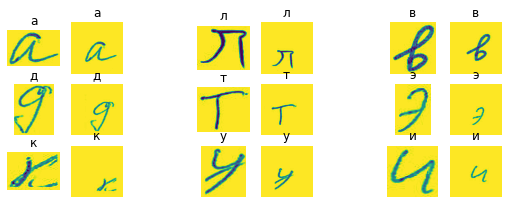

In [71]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(9, 9, 3*i + 1)
        im = crop_white_space(images[i])
        plt.imshow(im.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        ax = plt.subplot(9, 9, 3*i + 2)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
#         m = tf.math.greater(images[i], tf.constant([64.0]))
# #         erosion = -tf.nn.max_pool3d(~m, ksize=(5, 5, 1), padding='SAME',strides=1, name='erosion3D')
#         imm = np.bitwise_or(images[i].numpy().astype("uint8"), m)
# #         print(imm)
#         imm = crop_white_space(imm)
#         ax = plt.subplot(9, 9, 3*i + 3)
#         plt.imshow(imm)
#         plt.title(class_names[labels[i]])
#         plt.axis("off")
#         erosion = -tf.nn.max_pool2d(-x, ksize=(5, 5), stride=1, name='erosion2D')
#         kernel = np.ones((5, 5), np.uint8)
#         erode = cv2.erode(thresh, kernel, iterations = 1)
#         result = cv2.bitwise_or(img, erode)

In [89]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(80,80, 1))
]

In [104]:
def conv_2d_pooling_layers(filters):
    return [
        tf.keras.layers.Conv2D(
            filters,
            (2,2),
            activation='relu',
            padding='same'
        ),
        tf.keras.layers.MaxPooling2D()
    ]
core_layers = \
    conv_2d_pooling_layers(32) + \
    conv_2d_pooling_layers(64) + \
    conv_2d_pooling_layers(128)

In [105]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(33)
]

In [106]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 80, 80, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 80, 80, 32)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 40, 40, 64)        8256      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 128)      

In [107]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    dataset,
    validation_data = val_ds,
    epochs = 20
)

Epoch 1/20
30/30 [==============================] - 8s 246ms/step - loss: 3.2424 - accuracy: 0.1169 - val_loss: 3.6900 - val_accuracy: 0.0397
Epoch 2/20
30/30 [==============================] - 8s 256ms/step - loss: 2.1583 - accuracy: 0.4018 - val_loss: 4.1543 - val_accuracy: 0.0449
Epoch 3/20
30/30 [==============================] - 8s 257ms/step - loss: 1.5033 - accuracy: 0.5911 - val_loss: 4.2085 - val_accuracy: 0.0509
Epoch 4/20
30/30 [==============================] - 8s 259ms/step - loss: 1.1536 - accuracy: 0.6888 - val_loss: 4.2938 - val_accuracy: 0.0587
Epoch 5/20
30/30 [==============================] - 8s 263ms/step - loss: 0.8901 - accuracy: 0.7552 - val_loss: 4.2407 - val_accuracy: 0.0654
Epoch 6/20
30/30 [==============================] - 8s 265ms/step - loss: 0.6736 - accuracy: 0.8250 - val_loss: 4.2774 - val_accuracy: 0.0739
Epoch 7/20
30/30 [==============================] - 8s 260ms/step - loss: 0.5062 - accuracy: 0.8667 - val_loss: 4.6848 - val_accuracy: 0.0736
Epoch 

In [66]:
model.save('weight/20-epoch')

2022-01-27 12:27:27.002284: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weight/20-epoch/assets
